In [316]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Flatten, TextVectorization, Attention
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision, layers, metrics, backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve
mixed_precision.set_global_policy('mixed_float16')

In [317]:
ebnerd_type = "ebnerd_small"

In [318]:
# load datasets
behaviors = pd.read_parquet(f"drive/MyDrive/{ebnerd_type}/train/behaviors.parquet").dropna()
history = pd.read_parquet(f"drive/MyDrive/{ebnerd_type}/train/history.parquet").dropna()
articles = pd.read_parquet(f"drive/MyDrive/{ebnerd_type}/articles.parquet").dropna()
articles_embeddings = pd.read_parquet(f"drive/MyDrive/{ebnerd_type}/bert_base_multilingual_cased.parquet")

In [319]:
behaviors['article_id'] = behaviors['article_id'].astype(int)

In [320]:
behaviors.head()

,impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
679,1754731,9774074,2023-05-20 21:26:56,91.0,100.0,1,"[9774074, 9659345, 9651229, 9774079, 9767665, ...",[9767665],1763407,True,0.0,1.0,50.0,True,150096,453.0,100.0
1006,2437975,9766434,2023-05-25 06:45:38,92.0,100.0,1,"[9747962, 9744403, 9649171, 9779205, 9760091]",[9779205],1767026,True,1.0,0.0,90.0,False,150741,153.0,100.0
1009,2437981,9779205,2023-05-25 06:47:10,153.0,100.0,1,"[9780193, 9777026, 9277736, 9483850, 9779205, ...",[9775985],1767026,True,1.0,0.0,90.0,False,150741,45.0,100.0
1406,3208253,9756785,2023-05-20 04:48:47,241.0,100.0,1,"[9772355, 9772601, 9742172, 9772300, 9742173, ...",[9772355],2588560,True,1.0,1.0,70.0,False,305603,66.0,100.0
1407,3208257,9773137,2023-05-20 04:55:38,38.0,100.0,1,"[9772813, 9771916, 9771333, 9772635, 9756785, ...",[9770102],2588560,True,1.0,1.0,70.0,False,305603,0.0,100.0


In [321]:
history.head()

,user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed
0,13538,"[2023-04-27T10:17:43.000000, 2023-04-27T10:18:...","[100.0, 35.0, 100.0, 24.0, 100.0, 23.0, 100.0,...","[9738663, 9738569, 9738663, 9738490, 9738663, ...","[17.0, 12.0, 4.0, 5.0, 4.0, 9.0, 5.0, 46.0, 11..."
1,14241,"[2023-04-27T09:40:18.000000, 2023-04-27T09:40:...","[100.0, 46.0, 100.0, 70.0, 100.0, 100.0, 100.0...","[9738557, 9738528, 9738533, 9738684, 9739035, ...","[8.0, 9.0, 28.0, 17.0, 91.0, 21.0, 14.0, 27.0,..."
2,20396,"[2023-04-27T12:30:44.000000, 2023-04-27T12:31:...","[100.0, 59.0, nan, nan, 100.0, 100.0, nan, nan...","[9738760, 9738355, 9738355, 9739864, 9741788, ...","[49.0, 34.0, 0.0, 60.0, 180.0, 49.0, 0.0, 0.0,..."
3,34912,"[2023-04-29T07:12:49.000000, 2023-04-29T13:01:...","[100.0, 35.0, 44.0, 31.0, 100.0, 100.0, 100.0,...","[9741802, 9741804, 9741803, 9740087, 9742039, ...","[153.0, 7.0, 5.0, 6.0, 44.0, 44.0, 108.0, 10.0..."
4,37953,"[2023-04-27T19:17:10.000000, 2023-04-27T19:17:...","[14.0, 28.0, 29.0, nan, 36.0, 33.0, 50.0, 100....","[9739205, 9739202, 9737084, 9739274, 9739358, ...","[4.0, 16.0, 4.0, 0.0, 5.0, 5.0, 25.0, 48.0, 6...."


In [322]:
articles.head()

,article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,...,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
4140,8113223,Bengt Burgs store tv-sorg,Tv-kendissen gav for tre år siden et stort int...,2023-06-29 06:30:08,True,I 12 år var han ankermand på en af de største ...,2023-04-17 10:26:08,"[9723376, 9723405, 9723403, 9723391, 9723369]",article_default,https://ekstrabladet.dk/underholdning/bengt-bu...,...,"[PER, PER, ORG, PER, ORG, ORG, PROD, PER, PER,...","[Kendt, Underholdning, Film og tv]",414,[],underholdning,40638.0,16912.0,1323860.0,0.8872,Negative
6683,9232942,En ægte Dario er gået bort,Latinoen og smørtenoren har sunget og underhol...,2023-06-29 06:41:25,False,"Det er ikke mange mennesker, der skaber et beg...",2023-04-03 13:00:58,"[4626336, 9232886, 9232887, 7567959, 7806334, ...",article_default,https://ekstrabladet.dk/underholdning/dkkendte...,...,"[PROD, PER, LOC, MISC, PER, PER, ORG, PER, ORG...","[Kendt, Livsstil, Underholdning]",414,[425],underholdning,251397.0,29451.0,4352945.0,0.8485,Negative
7311,9321777,- Jeg måtte bare gøre noget,En forening af danske veteraner samler udstyr ...,2023-06-29 06:42:25,True,En camouflagefarvet firehjulstrækker kører ned...,2023-03-26 05:16:43,"[9687457, 9687451, 9687450, 9687454, 9687452, ...",article_default,https://ekstrabladet.dk/krimi/jeg-maatte-bare-...,...,"[LOC, LOC, LOC, ORG, ORG, LOC, ORG, PROD, ORG,...","[Konflikt og krig, Væbnet konflikt]",140,[],krimi,677524.0,27344.0,1994141.0,0.8126,Neutral
9416,9539752,De danske cykelstjerners skattefidus,Stort overblik:,2023-07-26 14:41:32,True,default\nFlere af de danske cykelstjerner er s...,2023-04-08 07:50:20,"[9539969, 9703138, 9704157, 9539969, 9704164, ...",article_standard_feature,https://ekstrabladet.dk/sport/cykling/de-dansk...,...,"[LOC, PER, PROD, LOC, PER, LOC, MISC, MISC, PE...","[Sport, Cykling]",142,[317],sport,825594.0,34314.0,1812518.0,0.8997,Neutral
9546,9550338,Danske Sofia: Dét sker der i 'private room',23-årige Sofia arbejder fuldtid som stripper -...,2023-06-29 06:45:44,True,black\nDa 23-årige Sofia kort før coronanedluk...,2023-02-20 15:26:05,"[9547382, 9547383, 9550926, 9550379, 9547378, ...",article_standard_feature,https://ekstrabladet.dk/underholdning/livsstil...,...,"[ORG, LOC, ORG, LOC, PER, LOC]","[Kendt, Livsstil, Erotik]",414,[441],underholdning,1330781.0,89969.0,1821540.0,0.8486,Neutral


In [323]:
articles_embeddings.head()

,article_id,google-bert/bert-base-multilingual-cased
0,3000022,"[-0.35060593, 0.0034366532, -0.1756858, -0.088..."
1,3000063,"[-0.0034481985, 0.22765873, -0.19700234, 0.060..."
2,3000613,"[-0.03811903, -0.030120859, -0.6928362, 0.0801..."
3,3000700,"[-0.29374197, -0.07282147, -0.0926456, -0.0540..."
4,3000840,"[0.0019190352, -0.010633812, -0.49158585, 0.17..."


In [324]:
train_behaviors = behaviors[behaviors['impression_time'] < '2023-05-23 07:00:00']
val_behaviors = behaviors[(behaviors['impression_time'] >= '2023-05-23 07:00:00') &
                        (behaviors['impression_time'] < '2023-05-24 07:00:00')]
test_behaviors = behaviors[behaviors['impression_time'] >= '2023-05-24 07:00:00']


In [325]:
# generate user-item interactions with positive and negative samples
test_user_item_pairs = []
val_user_item_pairs = []
train_user_item_pairs = []
unique_users = behaviors['user_id'].unique()
unique_items = articles['article_id'].unique()

for user_id in unique_users:
    # get all sessions for this user
    user_data = train_behaviors[train_behaviors['user_id'] == user_id]

    # iterate over each session to gather clicked and non-clicked inview articles
    for _, session in user_data.iterrows():
        # extract clicked and inview article IDs for the session
        clicked_articles = set(session['article_ids_clicked']) if len(session['article_ids_clicked']) > 0 else set()
        inview_articles = set(session['article_ids_inview']) if len(session['article_ids_inview']) > 0 else set()

        impression_id = session['impression_id']
        impression_time = session['impression_time']

        # add positive samples (clicked articles)
        for article_id in clicked_articles:
            train_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 1])  # Interaction = 1 for positive samples

        # identify non-clicked inview articles as additional negative samples
        non_clicked_inview = list(inview_articles - clicked_articles)

        non_clicked_inview = random.sample(non_clicked_inview, min(3 * len(clicked_articles), len(non_clicked_inview)))

        for article_id in non_clicked_inview:
            train_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 0])  # interaction = 0 for non-clicked inview articles

for user_id in unique_users:
    # get all sessions for this user
    user_data = val_behaviors[val_behaviors['user_id'] == user_id]

    # iterate over each session to gather clicked and non-clicked inview articles
    for _, session in user_data.iterrows():
        # extract clicked and inview article IDs for the session
        clicked_articles = set(session['article_ids_clicked']) if len(session['article_ids_clicked']) > 0 else set()
        inview_articles = set(session['article_ids_inview']) if len(session['article_ids_inview']) > 0 else set()

        impression_id = session['impression_id']
        impression_time = session['impression_time']

        # add positive samples (clicked articles)
        for article_id in clicked_articles:
            val_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 1])  # Interaction = 1 for positive samples

        # identify non-clicked inview articles as additional negative samples
        non_clicked_inview = random.sample(non_clicked_inview, min(3 * len(clicked_articles), len(non_clicked_inview)))


        for article_id in non_clicked_inview:
            val_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 0])  # interaction = 0 for non-clicked inview articles

for user_id in unique_users:
    # get all sessions for this user
    user_data = test_behaviors[test_behaviors['user_id'] == user_id]

    # iterate over each session to gather clicked and non-clicked inview articles
    for _, session in user_data.iterrows():
        # extract clicked and inview article IDs for the session
        clicked_articles = set(session['article_ids_clicked']) if len(session['article_ids_clicked']) > 0 else set()
        inview_articles = set(session['article_ids_inview']) if len(session['article_ids_inview']) > 0 else set()

        impression_id = session['impression_id']
        impression_time = session['impression_time']

        # add positive samples (clicked articles)
        for article_id in clicked_articles:
            test_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 1])  # Interaction = 1 for positive samples

        # identify non-clicked inview articles as additional negative samples
        non_clicked_inview = list(inview_articles - clicked_articles)
        non_clicked_inview = random.sample(non_clicked_inview, min(3 * len(clicked_articles), len(non_clicked_inview)))

        for article_id in non_clicked_inview:
            test_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 0])  # interaction = 0 for non-clicked inview articles


In [326]:
# convert to DataFrame
train_interactions_df = pd.DataFrame(train_user_item_pairs, columns=['user_id', 'article_id', 'impression_id', 'impression_time', 'interaction'])
val_interactions_df = pd.DataFrame(val_user_item_pairs, columns=['user_id', 'article_id', 'impression_id', 'impression_time', 'interaction'])
test_interactions_df = pd.DataFrame(test_user_item_pairs, columns=['user_id', 'article_id', 'impression_id', 'impression_time', 'interaction'])

In [327]:
train_interactions_df.head(20)

,user_id,article_id,impression_id,impression_time,interaction
0,1763407,9767665,1754731,2023-05-20 21:26:56,1
1,1763407,9651229,1754731,2023-05-20 21:26:56,0
2,1763407,9772830,1754731,2023-05-20 21:26:56,0
3,1763407,9774079,1754731,2023-05-20 21:26:56,0
4,1763407,9776287,3775838,2023-05-23 05:56:50,1
5,1763407,9776862,3775838,2023-05-23 05:56:50,0
6,1763407,9658650,3775838,2023-05-23 05:56:50,0
7,1763407,9738193,3775838,2023-05-23 05:56:50,0
8,1763407,9776870,3775839,2023-05-23 05:57:19,1
9,1763407,9773275,3775839,2023-05-23 05:57:19,0


In [328]:
test_interactions_df.head()

,user_id,article_id,impression_id,impression_time,interaction
0,1763407,9777910,201488614,2023-05-24 20:00:50,1
1,1763407,9775647,201488614,2023-05-24 20:00:50,0
2,1763407,9708656,201488614,2023-05-24 20:00:50,0
3,1763407,9775717,201488614,2023-05-24 20:00:50,0
4,1763407,9779141,201488617,2023-05-24 20:08:54,1


In [329]:
val_interactions_df.head()

,user_id,article_id,impression_id,impression_time,interaction
0,1763407,9778220,9613894,2023-05-23 18:45:55,1
1,1763407,9772344,9613894,2023-05-23 18:45:55,0
2,1763407,9772443,9613894,2023-05-23 18:45:55,0
3,1763407,9772442,9613894,2023-05-23 18:45:55,0
4,1763407,9778102,9613897,2023-05-23 18:45:38,1


In [330]:
train_interactions_df = pd.merge(
    train_interactions_df,
    articles[['article_id', 'category', 'premium']],
    on='article_id',
    how='left'
)

In [331]:
val_interactions_df = pd.merge(
    val_interactions_df,
    articles[['article_id', 'category', 'premium']],
    on='article_id',
    how='left'
)

In [332]:
test_interactions_df = pd.merge(
    test_interactions_df,
    articles[['article_id', 'category', 'premium']],
    on='article_id',
    how='left'
)

In [333]:
train_interactions_df['category'] = train_interactions_df['category'].fillna(-1).astype(int)
val_interactions_df['category'] = val_interactions_df['category'].fillna(-1).astype(int)
test_interactions_df['category'] = test_interactions_df['category'].fillna(-1).astype(int)

In [334]:
train_interactions_df.head()

,user_id,article_id,impression_id,impression_time,interaction,category,premium
0,1763407,9767665,1754731,2023-05-20 21:26:56,1,118,False
1,1763407,9651229,1754731,2023-05-20 21:26:56,0,118,False
2,1763407,9772830,1754731,2023-05-20 21:26:56,0,118,False
3,1763407,9774079,1754731,2023-05-20 21:26:56,0,118,False
4,1763407,9776287,3775838,2023-05-23 05:56:50,1,142,False


In [335]:
history_features = history.groupby('user_id').agg({
    'read_time_fixed': lambda x: np.nanmean([t for t in x if t is not None]),  # average read time
    'scroll_percentage_fixed': lambda x: np.nanmean([s for s in x if s is not None]),  # average scroll percentage
    'article_id_fixed': 'count'  # total clicks
}).reset_index()

history_features.columns = ['user_id', 'avg_read_time', 'avg_scroll_percentage', 'total_clicks']

<ipython-input-335-8ff48d8cb124>:3: RuntimeWarning: Mean of empty slice
  'scroll_percentage_fixed': lambda x: np.nanmean([s for s in x if s is not None]),  # average scroll percentage


In [336]:
train_interactions_df = pd.merge(
    train_interactions_df,
    history_features[['user_id', 'avg_read_time', 'avg_scroll_percentage', 'total_clicks']],
    on='user_id',
    how='left'
)
val_interactions_df = pd.merge(
    val_interactions_df,
    history_features[['user_id', 'avg_read_time', 'avg_scroll_percentage', 'total_clicks']],
    on='user_id',
    how='left'
)
test_interactions_df = pd.merge(
    test_interactions_df,
    history_features[['user_id', 'avg_read_time', 'avg_scroll_percentage', 'total_clicks']],
    on='user_id',
    how='left'
)

In [337]:
train_interactions_df.head()

,user_id,article_id,impression_id,impression_time,interaction,category,premium,avg_read_time,avg_scroll_percentage,total_clicks
0,1763407,9767665,1754731,2023-05-20 21:26:56,1,118,False,67.406158,90.676819,1
1,1763407,9651229,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1
2,1763407,9772830,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1
3,1763407,9774079,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1
4,1763407,9776287,3775838,2023-05-23 05:56:50,1,142,False,67.406158,90.676819,1


In [338]:
# fav category
article_category_map = dict(zip(articles['article_id'], articles['category']))

In [339]:
def get_favorite_category(row):
    """
    Determine the favorite category for a user based on the articles they have read.
    """
    user_id = row['user_id']
    article_ids = row['article_id_fixed']

    # map article IDs to categories using the dictionary
    categories = [article_category_map.get(article_id) for article_id in article_ids if article_id in article_category_map]

    # count the frequency of each category and get the most common one
    if categories:
        category_count = Counter(categories)
        favorite_category = category_count.most_common(1)[0][0]  # get the most common category
    else:
        favorite_category = 'Unknown'

    return pd.Series({'user_id': user_id, 'favorite_category': favorite_category})

In [340]:
user_favorite_categories = history.apply(get_favorite_category, axis=1)

In [341]:
user_favorite_categories.head()

,user_id,favorite_category
0,13538,118
1,14241,118
2,20396,414
3,34912,118
4,37953,118


In [342]:
train_interactions_df = pd.merge(
    train_interactions_df,
    user_favorite_categories,
    on='user_id',
    how='left'
)
val_interactions_df = pd.merge(
    val_interactions_df,
    user_favorite_categories,
    on='user_id',
    how='left'
)
test_interactions_df = pd.merge(
    test_interactions_df,
    user_favorite_categories,
    on='user_id',
    how='left'
)

In [343]:
train_interactions_df.head()

,user_id,article_id,impression_id,impression_time,interaction,category,premium,avg_read_time,avg_scroll_percentage,total_clicks,favorite_category
0,1763407,9767665,1754731,2023-05-20 21:26:56,1,118,False,67.406158,90.676819,1,118
1,1763407,9651229,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118
2,1763407,9772830,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118
3,1763407,9774079,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118
4,1763407,9776287,3775838,2023-05-23 05:56:50,1,142,False,67.406158,90.676819,1,118


In [344]:
train_interactions_df['favorite_category'].fillna(-1, inplace=True)
val_interactions_df['favorite_category'].fillna(-1, inplace=True)
test_interactions_df['favorite_category'].fillna(-1, inplace=True)

<ipython-input-344-66b09f608afc>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_interactions_df['favorite_category'].fillna(-1, inplace=True)
<ipython-input-344-66b09f608afc>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [345]:
train_interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3004 non-null   uint32        
 1   article_id             3004 non-null   int32         
 2   impression_id          3004 non-null   int64         
 3   impression_time        3004 non-null   datetime64[ns]
 4   interaction            3004 non-null   int64         
 5   category               3004 non-null   int64         
 6   premium                2488 non-null   object        
 7   avg_read_time          3004 non-null   float32       
 8   avg_scroll_percentage  3004 non-null   float32       
 9   total_clicks           3004 non-null   int64         
 10  favorite_category      3004 non-null   int64         
dtypes: datetime64[ns](1), float32(2), int32(1), int64(5), object(1), uint32(1)
memory usage: 211.3+ KB


In [346]:
# user info
user_info = behaviors[['user_id', 'gender', 'postcode', 'age', 'is_subscriber',
                            'next_read_time', 'next_scroll_percentage']].sort_values(by='next_read_time', ascending=False).drop_duplicates(subset=['user_id'])

In [347]:
train_interactions_df = pd.merge(
    train_interactions_df,
    user_info,
    on='user_id',
    how='left'
)
val_interactions_df = pd.merge(
    val_interactions_df,
    user_info,
    on='user_id',
    how='left'
)
test_interactions_df = pd.merge(
    test_interactions_df,
    user_info,
    on='user_id',
    how='left'
)

In [348]:
train_interactions_df.head()

,user_id,article_id,impression_id,impression_time,interaction,category,premium,avg_read_time,avg_scroll_percentage,total_clicks,favorite_category,gender,postcode,age,is_subscriber,next_read_time,next_scroll_percentage
0,1763407,9767665,1754731,2023-05-20 21:26:56,1,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0
1,1763407,9651229,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0
2,1763407,9772830,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0
3,1763407,9774079,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0
4,1763407,9776287,3775838,2023-05-23 05:56:50,1,142,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0


In [349]:
train_interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 3004 non-null   uint32        
 1   article_id              3004 non-null   int32         
 2   impression_id           3004 non-null   int64         
 3   impression_time         3004 non-null   datetime64[ns]
 4   interaction             3004 non-null   int64         
 5   category                3004 non-null   int64         
 6   premium                 2488 non-null   object        
 7   avg_read_time           3004 non-null   float32       
 8   avg_scroll_percentage   3004 non-null   float32       
 9   total_clicks            3004 non-null   int64         
 10  favorite_category       3004 non-null   int64         
 11  gender                  3004 non-null   float64       
 12  postcode                3004 non-null   float64 

In [248]:
# save to parquet - no embeddings
train_interactions_df.to_parquet(f"drive/MyDrive/{ebnerd_type}/interactions_train.parquet")
val_interactions_df.to_parquet(f"drive/MyDrive/{ebnerd_type}/interactions_val.parquet")
test_interactions_df.to_parquet(f"drive/MyDrive/{ebnerd_type}/interactions_test.parquet")

In [350]:
# add embeddings
train_interactions_df = pd.merge(
    train_interactions_df,
    articles_embeddings,
    on='article_id',
    how='left'
)
val_interactions_df = pd.merge(
    val_interactions_df,
    articles_embeddings,
    on='article_id',
    how='left'
)
test_interactions_df = pd.merge(
    test_interactions_df,
    articles_embeddings,
    on='article_id',
    how='left'
)

In [351]:
train_interactions_df.head()

,user_id,article_id,impression_id,impression_time,interaction,category,premium,avg_read_time,avg_scroll_percentage,total_clicks,favorite_category,gender,postcode,age,is_subscriber,next_read_time,next_scroll_percentage,google-bert/bert-base-multilingual-cased
0,1763407,9767665,1754731,2023-05-20 21:26:56,1,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.07177114, 0.10371003, -0.09474098, 0.18368..."
1,1763407,9651229,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.025337465, 0.088963434, -0.20202443, 0.212..."
2,1763407,9772830,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.102214694, 0.117208585, -0.15910608, 0.192..."
3,1763407,9774079,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.11082654, -0.052438408, -0.38585418, -0.04..."
4,1763407,9776287,3775838,2023-05-23 05:56:50,1,142,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.010322263, 0.10949625, -0.1956074, 0.12482..."


In [352]:
train_interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   user_id                                   3004 non-null   uint32        
 1   article_id                                3004 non-null   int32         
 2   impression_id                             3004 non-null   int64         
 3   impression_time                           3004 non-null   datetime64[ns]
 4   interaction                               3004 non-null   int64         
 5   category                                  3004 non-null   int64         
 6   premium                                   2488 non-null   object        
 7   avg_read_time                             3004 non-null   float32       
 8   avg_scroll_percentage                     3004 non-null   float32       
 9   total_clicks                  

In [353]:
# save to parquet - embeddings
train_interactions_df.to_parquet(f"drive/MyDrive/{ebnerd_type}/interactions_train_embeddings.parquet")
val_interactions_df.to_parquet(f"drive/MyDrive/{ebnerd_type}/interactions_val_embeddings.parquet")
test_interactions_df.to_parquet(f"drive/MyDrive/{ebnerd_type}/interactions_test_embeddings.parquet")

In [354]:
train_interactions_df.head()

,user_id,article_id,impression_id,impression_time,interaction,category,premium,avg_read_time,avg_scroll_percentage,total_clicks,favorite_category,gender,postcode,age,is_subscriber,next_read_time,next_scroll_percentage,google-bert/bert-base-multilingual-cased
0,1763407,9767665,1754731,2023-05-20 21:26:56,1,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.07177114, 0.10371003, -0.09474098, 0.18368..."
1,1763407,9651229,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.025337465, 0.088963434, -0.20202443, 0.212..."
2,1763407,9772830,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.102214694, 0.117208585, -0.15910608, 0.192..."
3,1763407,9774079,1754731,2023-05-20 21:26:56,0,118,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.11082654, -0.052438408, -0.38585418, -0.04..."
4,1763407,9776287,3775838,2023-05-23 05:56:50,1,142,False,67.406158,90.676819,1,118,0.0,1.0,50.0,True,638.0,100.0,"[-0.010322263, 0.10949625, -0.1956074, 0.12482..."


In [355]:
# split into test, train, validation
train_df = train_interactions_df
val_df = val_interactions_df
test_df = test_interactions_df
print(f"Train set: {len(train_df)}, Validation set: {len(val_df)}, Test set: {len(test_df)}")

Train set: 3004, Validation set: 536, Test set: 688


In [356]:
unique_users = behaviors['user_id'].unique()
unique_articles = behaviors['article_id'].unique()
unique_categories = articles['category'].unique()

In [357]:
categorical_features = ['user_id', 'article_id', 'category', 'favorite_category', 'gender', 'postcode', 'is_subscriber']

In [358]:
encoders = {}
for feature in categorical_features:
    encoder = LabelEncoder()
    train_df[feature] = encoder.fit_transform(train_df[feature])
    val_df[feature] = encoder.fit_transform(val_df[feature])
    test_df[feature] = encoder.fit_transform(test_df[feature])
    encoders[feature] = encoder

In [359]:
# normalize numerical features
numerical_features = ['avg_read_time', 'avg_scroll_percentage', 'total_clicks', 'age', 'next_read_time', 'next_scroll_percentage']
scaler = StandardScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
val_df[numerical_features] = scaler.transform(val_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

In [360]:
# extract BERT embeddings into a numpy array
train_df['bert_embeddings'] = train_df['google-bert/bert-base-multilingual-cased'].apply(lambda x: np.array(x))
train_df_bert_embeddings = np.stack(train_df['bert_embeddings'].values)

val_df['bert_embeddings'] = val_df['google-bert/bert-base-multilingual-cased'].apply(lambda x: np.array(x))
val_df_bert_embeddings = np.stack(val_df['bert_embeddings'].values)

test_df['bert_embeddings'] = test_df['google-bert/bert-base-multilingual-cased'].apply(lambda x: np.array(x))
test_df_bert_embeddings = np.stack(test_df['bert_embeddings'].values)

In [361]:
def prepare_inputs(df):
    categorical_inputs = df[categorical_features].values
    numerical_inputs = df[numerical_features].values
    bert_embeddings = np.stack(df['bert_embeddings'].values)
    return [categorical_inputs, numerical_inputs, bert_embeddings]

In [362]:
train_inputs = prepare_inputs(train_df)
val_inputs = prepare_inputs(val_df)
test_inputs = prepare_inputs(test_df)

train_labels = train_df['interaction'].values
val_labels = val_df['interaction'].values
test_labels = test_df['interaction'].values

In [363]:
# define feature input layers
categorical_input = layers.Input(shape=(len(categorical_features),), name='categorical_input')
numerical_input = layers.Input(shape=(len(numerical_features),), name='numerical_input')
bert_input = layers.Input(shape=(train_df_bert_embeddings.shape[1],), name='bert_input')

In [364]:
# embedding and dense layers for categorical features
x1 = layers.Embedding(input_dim=len(unique_users), output_dim=32)(categorical_input)
x1 = layers.Flatten()(x1)

# dense layers for numerical features
x2 = layers.Dense(32, activation='relu')(numerical_input)

# use BERT embeddings directly
x3 = layers.Dense(128, activation='relu')(bert_input)

# concatenate all features
x = layers.Concatenate()([x1, x2, x3])
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

In [366]:
# define the model
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = -alpha_t * K.pow((1 - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

model = Model(inputs=[categorical_input, numerical_input, bert_input], outputs=output)
model.compile(optimizer='adam', loss=focal_loss(gamma=2, alpha=0.25), metrics=[metrics.AUC()])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ categorical_input         │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 7, 32)          │          2,368 │ categorical_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numerical_input           │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 224)            │              0 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 32)             │            224 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 128)            │         98,432 │ bert_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 384)            │              0 │ flatten_6[0][0],       │
│ (Concatenate)             │                        │                │ dense_32[0][0],        │
│                           │                        │                │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 64)             │         24,640 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64)             │              0 │ dense_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 32)             │          2,080 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 1)              │             33 │ dense_35[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 127,777 (499.13 KB)

 Trainable params: 127,777 (499.13 KB)

 Non-trainable params: 0 (0.00 B)

In [367]:
# fine tuning
# lr scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [368]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    mode='max'
)
# train the model
history = model.fit(
    [train_inputs[0], train_inputs[1], train_inputs[2]], train_labels,
    validation_data=([val_inputs[0], val_inputs[1], val_inputs[2]], val_labels),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - auc_7: 0.5239 - loss: 0.8909 - val_auc_7: 0.6297 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_7: 0.5142 - loss: 0.2644 - val_auc_7: 0.6636 - val_loss: 0.1183 - learning_rate: 0.0010
Epoch 3/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: auc_7,loss,val_auc_7,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: auc_7,loss,val_auc_7,val_loss,learning_rate
  current = self.get_monitor_value(logs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_7: 0.5395 - loss: 0.1001 - val_auc_7: 0.6094 - val_loss: 0.0686 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_7: 0.5538 - loss: 0.0656 - val_auc_7: 0.6181 - val_loss: 0.0590 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_7: 0.5408 - loss: 0.0591 - val_auc_7: 0.5905 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_7: 0.5407 - loss: 0.0601 - val_auc_7: 0.5969 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_7: 0.5262 - loss: 0.0547 - val_auc_7: 0.5823 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_7: 0.5830 - loss: 0.0574 - val_auc_7: 0.5845 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_7: 0.5556 - loss: 0.0558 - val_auc_7: 0.5504 - val_loss: 0.0566 - learning_rate: 0.0010
Epo

In [369]:
# predict on the test set
test_preds = model.predict([test_inputs[0], test_inputs[1], test_inputs[2]]).flatten()
test_df['predicted_score'] = test_preds

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step


In [370]:
test_df['predicted_score'] = test_df['predicted_score'].astype('float32')
test_data = test_df.sort_values(by=['impression_id', 'predicted_score'], ascending=[True, False])
print(test_df[['impression_id', 'user_id', 'article_id','interaction', 'predicted_score']])

     impression_id  user_id  article_id  interaction  predicted_score
0        201488614       26         143            1         0.316162
1        201488614       26         113            0         0.255859
2        201488614       26          53            0         0.349365
3        201488614       26         115            0         0.356445
4        201488617       26         197            1         0.385498
..             ...      ...         ...          ...              ...
683      417474708       33         223            0         0.362061
684      525088924       33         200            1         0.393311
685      525088924       33         192            0         0.358643
686      525088924       33         209            0         0.256592
687      525088924       33         211            0         0.183105

[688 rows x 5 columns]


In [371]:
#metrics
# AUC
def calculate_auc(data):
    """Calculate AUC for a given dataset."""
    if data['interaction'].nunique() < 2:  # AUC needs at least one positive and one negative label
        return np.nan
    return roc_auc_score(data['interaction'], data['predicted_score'])

# MRR calculation
def calculate_mrr(data):
    """Calculate MRR for a given dataset."""
    sorted_data = data.sort_values(by='predicted_score', ascending=False)
    ranks = sorted_data['interaction'].values
    for rank, interaction in enumerate(ranks, start=1):
        if interaction == 1:
            return 1 / rank
    return 0

# NDCG calculation
def dcg(scores, k):
    """Calculate Discounted Cumulative Gain."""
    return sum([score / np.log2(idx + 2) for idx, score in enumerate(scores[:k])])

def calculate_ndcg(data, k):
    """Calculate NDCG for a given dataset and cutoff k."""
    sorted_data = data.sort_values(by='predicted_score', ascending=False)
    ideal_sorted_data = data.sort_values(by='interaction', ascending=False)
    dcg_k = dcg(sorted_data['interaction'].values, k)
    idcg_k = dcg(ideal_sorted_data['interaction'].values, k)
    return dcg_k / idcg_k if idcg_k > 0 else 0


In [372]:
def evaluate_model(test_df):
    """Evaluate the model using AUC, MRR, and NDCG metrics."""
    auc = test_df.groupby('impression_id').apply(calculate_auc).mean()
    mrr = test_df.groupby('impression_id').apply(calculate_mrr).mean()
    ndcg3 = test_df.groupby('impression_id').apply(lambda x: calculate_ndcg(x, k=3)).mean()
    ndcg5 = test_df.groupby('impression_id').apply(lambda x: calculate_ndcg(x, k=5)).mean()

    print(f"AUC: {auc:.4f}")
    print(f"MRR: {mrr:.4f}")
    print(f"NDCG@3: {ndcg3:.4f}")
    print(f"NDCG@5: {ndcg5:.4f}")

In [373]:
# evaluate model
evaluate_model(test_df)

<ipython-input-372-65e93270f400>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  auc = test_df.groupby('impression_id').apply(calculate_auc).mean()
<ipython-input-372-65e93270f400>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mrr = test_df.groupby('impression_id').apply(calculate_mrr).mean()
<ipython-input-372-65e93270f400>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

AUC: 0.5252
MRR: 0.5378
NDCG@3: 0.5532
NDCG@5: 0.6534


<ipython-input-372-65e93270f400>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg5 = test_df.groupby('impression_id').apply(lambda x: calculate_ndcg(x, k=5)).mean()


In [374]:
def evaluate_by_impression(test_data):
    results = []
    grouped = test_data.groupby('impression_id')

    for impression_id, group in grouped:
        auc = calculate_auc(group)
        mrr = calculate_mrr(group)
        ndcg3 = calculate_ndcg(group, 3)
        ndcg5 = calculate_ndcg(group, 5)
        ndcg10 = calculate_ndcg(group, 10)

        # Append the result as a dictionary
        results.append({
            'impression_id': impression_id,
            'AUC': auc,
            'MRR': mrr,
            'NDCG@3': ndcg3,
            'NDCG@5': ndcg5,
            'NDCG@10': ndcg10
        })

    # Convert results to DataFrame
    return pd.DataFrame(results)

In [375]:
results = evaluate_by_impression(test_df)
print(results)

     impression_id       AUC       MRR   NDCG@3    NDCG@5   NDCG@10
0          2437975  0.000000  0.250000  0.00000  0.430677  0.430677
1          2437981  1.000000  1.000000  1.00000  1.000000  1.000000
2          3240446  1.000000  1.000000  1.00000  1.000000  1.000000
3          3240447  0.333333  0.333333  0.50000  0.500000  0.500000
4          3240450  0.666667  0.500000  0.63093  0.630930  0.630930
..             ...       ...       ...      ...       ...       ...
167      528650222  1.000000  1.000000  1.00000  1.000000  1.000000
168      528650223  0.333333  0.333333  0.50000  0.500000  0.500000
169      528650224  1.000000  1.000000  1.00000  1.000000  1.000000
170      576856323  0.333333  0.333333  0.50000  0.500000  0.500000
171      576856326  0.000000  0.250000  0.00000  0.430677  0.430677

[172 rows x 6 columns]


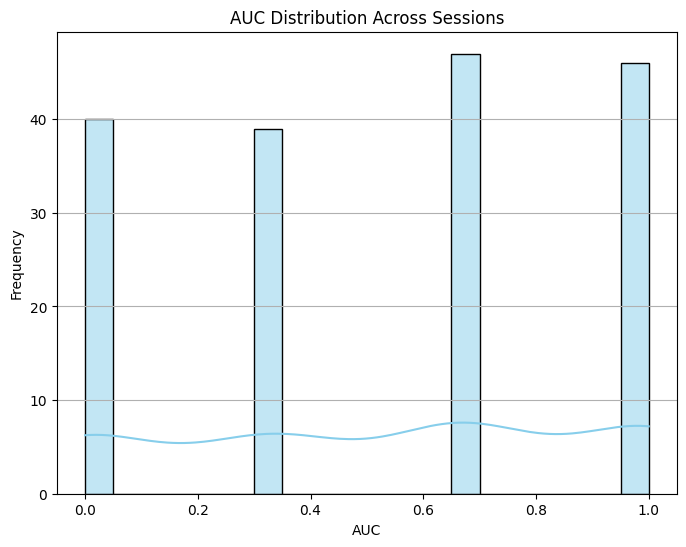

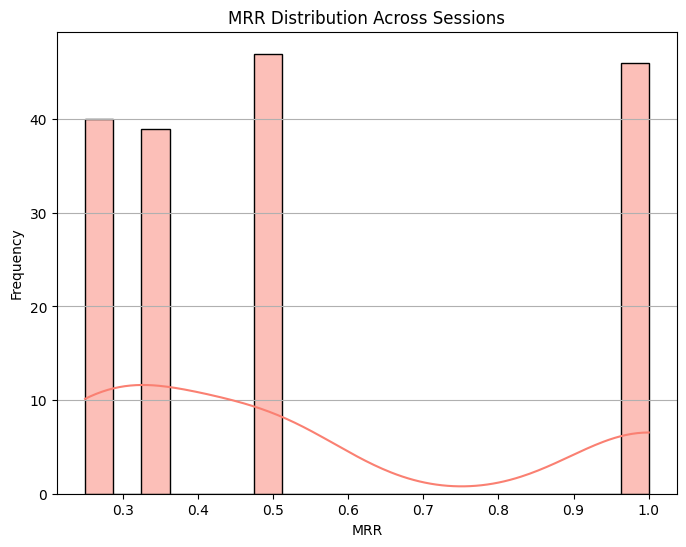

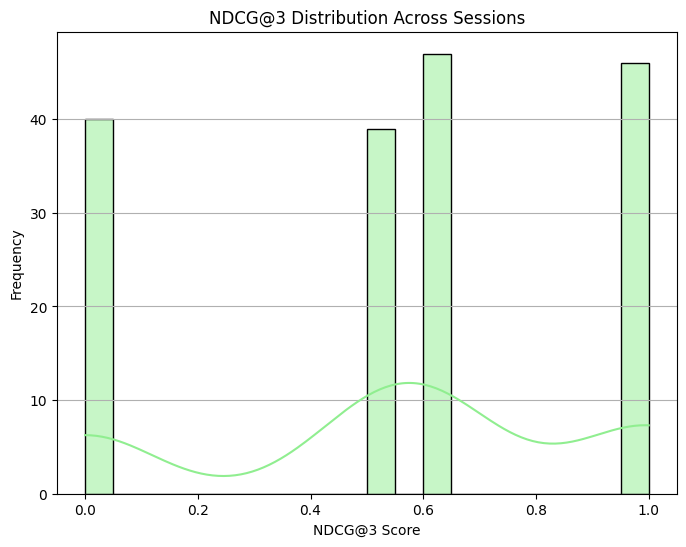

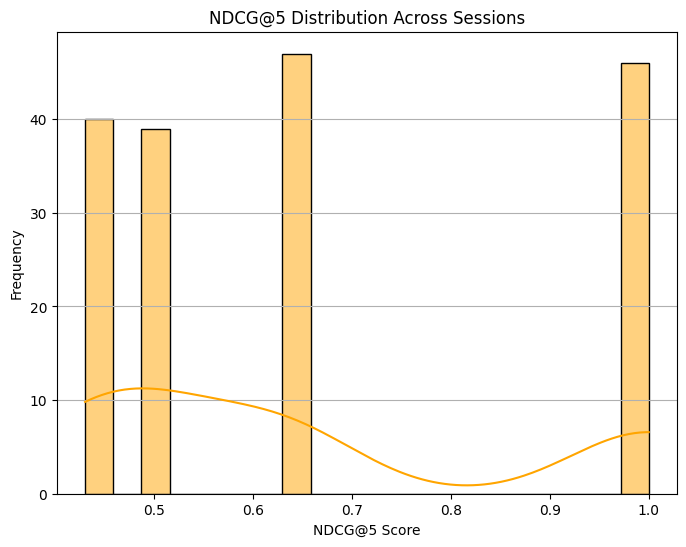

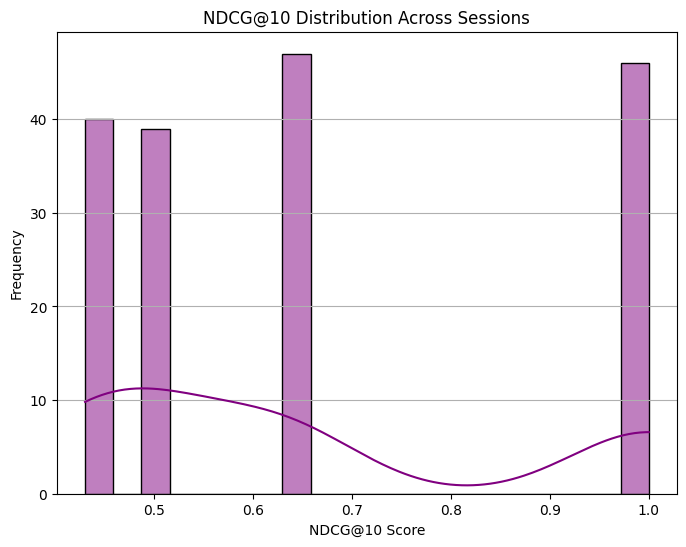

In [376]:
# Set the number of bins for histograms
bins = 20

# Plot 1: AUC Distribution Across Sessions
plt.figure(figsize=(8, 6))
sns.histplot(results['AUC'], kde=True, color="skyblue", bins=bins)
plt.title("AUC Distribution Across Sessions")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Plot 2: MRR Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['MRR'], kde=True, color="salmon", bins=bins)
plt.title("MRR Distribution Across Sessions")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Plot 3: NDCG@3 Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['NDCG@3'], kde=True, color="lightgreen", bins=bins)
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG@3 Score")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Plot 4: NDCG@5 Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['NDCG@5'], kde=True, color="orange", bins=bins)
plt.title("NDCG@5 Distribution Across Sessions")
plt.xlabel("NDCG@5 Score")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Plot 5: NDCG@10 Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['NDCG@10'], kde=True, color="purple", bins=bins)
plt.title("NDCG@10 Distribution Across Sessions")
plt.xlabel("NDCG@10 Score")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()